In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
import random
import sys
import os
import importlib
import utils
import matplotlib.pyplot as plt
import numpy as np
import warnings
from torch.utils.data import DataLoader, TensorDataset

current_folder = os.getcwd()
if current_folder not in sys.path:
    sys.path.append(current_folder)
from utils import few_shot_comparison, plot_tsne
from collections import defaultdict
from sklearn.manifold import TSNE

warnings.filterwarnings('ignore')
torch.manual_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"

# Few-Shot Learning: Wprowadzenie

Tradycyjne uczenie nadzorowane (supervised learning) opiera się na dużych zbiorach danych z wieloma oznakowanymi (labeled) przykładami na klasę. W przeciwieństwie do tego, **few-shot learning (FSL)** ma na celu umożliwienie klasyfikacji danych nowych klas na **bardzo niewielkiej** liczbie oznakowanych przykładów, nawet 1–5 na klasę.

W praktyce few-shot learning często nie wymaga pełnego douczania modelu: zazwyczaj korzysta się z wcześniej wytrenowanego modelu (backbone), który jest zamrażany, a klasyfikacja opiera się na porównywaniu embeddingów (przypomnienie: embedding – numeryczna reprezentacja przykładu uzyskana z modelu sztucznej inteligencji, która koduje jego istotne cechy i pozwala porównywać podobieństwo między różnymi przykładami), np. za pomocą metod metrycznych. W niektórych wariantach możliwe jest także douczanie jedynie ostatnich warstw lub niewielkiej części modelu, aby lepiej dopasować go do nowego zadania.

W niniejszym notatniku zostaną zaprezentowane oba podejścia — metody, które nie wymagają dalszego treningu, jak i takie, które dopuszczają ograniczone douczanie modelu.

[Źródło: IBM, 2023](https://www.ibm.com/think/topics/few-shot-learning?.com).

---

## Dlaczego Few-Shot Learning jest przydatne

Few-shot learning jest zaprojektowane dla przypadków, w których standardowe uczenie nadzorowane jest niepraktyczne lub nieefektywne. Poniżej przedstawiono główne powody, dla kiedy metody few-shot są przydatne:

[Źródło: DataCamp, 2023](https://www.datacamp.com/blog/what-is-few-shot-learning?.com).

---

### 1. Dane są drogie lub trudne do zebrania

W wielu dziedzinach zebranie dużych, oznakowanych zbiorów danych jest niemożliwe.  

Przykłady:
- **Obrazowanie medyczne:** wymaga wykwalifikowanego radiologa lub patologa  
- **Rzadkie choroby:** dostępnych jest tylko kilka przypadków pacjentów  
- **Monitoring dzikiej przyrody:** niektóre gatunki są rzadkie, zagrożone lub trudne do sfotografowania  
- **Defekty przemysłowe:** usterki zdarzają się rzadko, więc przykłady są nieliczne  

W takich przypadkach:
- Zebranie tysięcy przykładów na klasę jest nierealistyczne  
- Tradycyjne modele głębokiego uczenia, przy bardzo małych zbiorach danych, przeuczają się (overfit)

Few-shot learning rozwiązuje ten problem poprzez:
- Wykorzystanie **wcześniejszej wiedzy zdobytej z innych danych** (pre-trained models)
- Wymaganie tylko kilku oznakowanych przykładów do rozpoznania nowej klasy  

**Kluczowe założenie:** model już nauczył się reprezentować podobne dane, a kilka przykładów określa tylko to, co nowe 

[Źródło: DataCamp, 2023](https://www.datacamp.com/blog/what-is-few-shot-learning?.com).

---

### 2. Wymagana jest szybka adaptacja do nowych zadań

W wielu zastosowaniach nowe zadania (lub klasy) pojawiają się często i modele muszą się szybko dostosowywać.  

Przykłady:
- **Systemy spersonalizowane:** model dostosowuje się do preferencji nowego użytkownika  
- **Systemy bezpieczeństwa:** pojawiają się nowe wzorce ataków lub anomalie  
- **Robotyka:** roboty napotykają nowe obiekty lub środowiska  
- **Moderacja treści:** pojawiają się nowe rodzaje treści lub trendy  

W takich przypadkach:
- Retraining dużego modelu od zera jest powolny i kosztowny obliczeniowo  
- Zebranie dużych zbiorów danych dla każdego nowego zadania jest niepraktyczne  

Few-shot learning pozwala:
- Dodawać nowe klasy przy użyciu tylko kilku przykładów  
- Unikać pełnego retreningu modelu  
- Bardzo szybko adaptować model  

Dzięki temu FSL jest odpowiednie do uczenia „w locie”

[Źródło: DataCamp, 2023](https://www.datacamp.com/blog/what-is-few-shot-learning?.com).

---

### 3. Efektywne wykorzystanie wcześniej zdobytej wiedzy

Few-shot learning opiera się na założeniu, że modele powinny ponownie wykorzystywać to, czego już się nauczyły.  

Nowoczesne modele uczenia maszynowego są często:
- Wstępnie trenowane na ogromnych zbiorach danych  
- Bogate w reprezentacje ogólnego zastosowania  

Przykłady:
- Modele computer vision trenowane na ImageNet  
- Modele językowe trenowane na dużych korpusach tekstów  
- Modele mowy trenowane na dużych zbiorach danych audio  

Few-shot learning wykorzystuje to poprzez:
- Zachowanie wstępnej reprezentacji bez zmian  
- Użycie kilku przykładów do określenia nowych zadań w przestrzeni reprezentacji  

Zamiast uczyć się od zera:
- Model wykorzystuje podobieństwo, odległość lub kontekst  
- Dzięki temu wiedza ze starych zadań wykorzystywana jest dla nowych

To prowadzi do:
- Lepszej generalizacji  
- Mniejszego zapotrzebowania na dane  
- Efektywniejszego wykorzystania zasobów obliczeniowych

[Źródło: DataCamp, 2023](https://www.datacamp.com/blog/what-is-few-shot-learning?.com)

---

### Podsumowanie

Few-shot learning jest przydatne, gdy:
- Duże oznakowane zbiory danych są niedostępne  
- Wymagana jest szybka adaptacja  

W skrócie: FSL przesuwa fokus z *uczenia się wyłącznie z danych* na *efektywne wykorzystanie już nabytej wiedzy* 

---

### Kluczowe pojęcia

- **N-way K-shot learning:**  
  - **N** = liczba klas do sklasyfikowania  
  - **K** = liczba oznakowanych przykładów na klasę  
  Przykład: 5-way 1-shot = klasyfikacja 5 klas z 1 oznakowanym przykładem każda 

- **Zbiór pomocniczy (Support Set):** mały oznakowany zbiór danych używany do nauki/adaptacji 
- **Zbiór zapytań (Query Set):** zbiór nowych, nieoznakowanych przykładów do sklasyfikowania

[Źródło: Jaimlr, 2023](https://jaimlr.github.io/Journal-of-Artificial-Intelligence-Machine-Learning-Research/few-shot-learning-strategies-by-loveleen-narang.html?.com)


# Metric-Based Few-Shot Learning

**Cel:**  
Zamiast trenować pełny klasyfikator od podstaw, celem metric-based few-shot learningu (MBFSL) jest nauczenie modelu **przestrzeni cech (embedding space)**, w której możliwe jest mierzenie podobieństwa między przykładami danych.

W przypadkach, gdy posiadamy bardzo małą ilość danych, tradycyjne uczenie nadzorowane może być nieefektywne i prowadzić do przeuczenia. W przeciwieństwie do tego podejścia, metody MBFSL wykorzystują wcześniej wytrenowane modele (backbone), które uczą się ogólnych reprezentacji danych na dużych zbiorach treningowych. Takie modele mapują dane wejściowe do przestrzeni chech, w której przykłady z jednej klasy powinny znajdować się blisko siebie, a przykłady należące do różnych klas — dalej od siebie. Klasyfikacja nowych przykładów odbywa się poprzez porównywanie embeddingów (np. za pomocą odległości euklidesowej lub podobieństwa cosinusowego), bez konieczności trenowania klasycznego klasyfikatora.

[Źródło: IBM, 2023](https://www.ibm.com/think/topics/few-shot-learning)


---

## Przykłady podejść metrycznych

- **Nearest Neighbor (NN):** klasyfikuje przykład zapytania na podstawie najbardziej podobnego przykładu ze zbioru pomocniczego w przestrzeni embeddingów (najbardziej podstawowa metoda, wykorzystamy ją jako baseline do porównania z innymi metodami)
- **Prototypical Networks:** tworzą prototyp każdej z klas na podstawie średniego wektora cech uzyskanego ze zbioru pomocniczego.
- **Matching Networks:** porównują embeddingi punktu ze zbioru zapytań z embeddingami wszystkich puntków ze zbioru pomocniczego przy wykorzystaniu systemu uwagi (attention).  
- **Siamese Networks:** uczą sieć, która bezpośrednio przewiduje, czy dwie próbki są z tej samej klasy — tzn. uczą metryki podobieństwa.

[Źródło: IBM, 2023](https://www.ibm.com/think/topics/few-shot-learning?.com).

---

## Główne założenia Prototypical Networks

1. **Stwórz embeddingi dla wszystkich przykłądów**  
   - Sieć neuronowa (lub inna funkcja) mapuje każdy przykład $x$ na embedding $f(x)$.  
   - Dla poprawnie działającego modelu, embeddingi przykładów tej samej klasy są blisko siebie, a różnych klas daleko.
     
3. **Oblicz „prototyp” każdej klasy**  
   - Dla każdej klasy $c$ oblicz **średni embedding** elementów ze zbioru pomocniczego:  
     $$
     \mathbf{p}_c = \frac{1}{K} \sum_{i=1}^{K} f(x_i^c)
     $$
     gdzie $x_i^c$ to $i$‑ty przykład klasy $c$, a $K$ to moc zbioru pomocniczego na klasę.  
   - Prototyp to tak naprawdę centrum klastra w przestrzeni cech  

4. **Klasyfikacja przykładów zapytań**  
   - Dla nowego przykładu $x_q$ oblicz jego embedding $f(x_q)$.  
   - Zmierz odległość do każdego prototypu (np. odległość euklidesowa lub cosinusowa).  
   - Przypisz $x_q$ do klasy z **najbliższym prototypem**
     
[Źródło: mgx.dev, 2025](https://mgx.dev/insights/few-shot-learning-foundational-principles-methodologies-applications-and-future-directions/125229aa85474e198eda6582b8847abc).

**Intuicja:**  
Wyobraź sobie wykres 2D, gdzie punkty reprezentują cechy przykładów:  
- Punkty tej samej klasy tworzą grupy (*cluster*)  
- Prototypy są „środkiem” każdej grupy  
- Nowe punkty klasyfikowane są na podstawie bliskości do tych środków 

Źródło: [IBM, 2023](https://www.ibm.com/think/topics/few-shot-learning?.com)

---

### Prototypical Networks- cechy

| Cechy | Prototypical Network |
|-------|--------------------|
| Reprezentacja klasy | Prototyp (średnia) |
| Porównanie zapytania | Query ↔ Prototyp |
| Elastyczność | Ograniczona do średniej klasy |
| Złożoność | Niska |

---

### Zalety Prototypical Networks

- Prosta i intuicyjna metoda – prototypy reprezentują „centrum” każdej klasy  
- Wysoka efektywność przy pretrenowanych embeddingach  
- Dodanie nowej klasy wymaga jedynie obliczenia nowego prototypu, bez konieczności trenowania całego modelu  

[Źródło: Snell et al., 2017](https://arxiv.org/abs/1703.05175)


Poniżej przedstawiamy przykład działania Prototypical Network na zbiorze danych **CIFAR-10** z wykorzystaniem **backbone ResNet-18**.  

Wybraliśmy CIFAR-10, ponieważ jest to popularny, niewielki, dobrze znany zbiór kolorowych obrazów $32px/32px$ z 10 klasami (auta, koty, ptaki...), co umożliwia szybkie eksperymenty i łatwe wizualizacje. Dane poddajemy standardowym transformacjom: ToTensor, Resize(224) oraz Normalize z odpowiednimi wartościami średnich i odchyleń standardowych. Transformacje te są wymagane przez wybrany backbone, ponieważ jego architektura i wagi były pretrenowane na obrazach o takich samych rozmiarach i normalizacji.

Backbone ResNet-18 jest powszechnie stosowaną siecią do ekstrakcji cech, względnie małą, zapewniającą dobre embeddingi bez potrzeby trenowania całego modelu od podstaw.  

W dalszej części notatnika, prezentując kolejne metody MBFSL, będziemy korzystać z tych samych ustawień – tego samego zbioru danych oraz backbone – aby umożliwić uczciwe porównanie wyników oraz tych samych parametrów few-shot lerningu (n_way, k_shot, n_query) - można je zmianiać i sprawdzać działanie metod dla ich różnych wartości.  
Do porównania posłuży nam prosta metoda Nearest-Neighbor (NN), która klasyfikuje nowe przykłady na podstawie najbardziej podobnego punktu w przestrzeni embeddingów.


In [2]:
n_way = 4 #liczba klas do sklasyfikowania
k_shot = 5 #liczba oznakowanych przykładów na klasę
n_query = 5 #liczba przykładów, na których testujemy, na klasę

In [3]:
transform = T.Compose([
    T.Resize(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

In [4]:
selected_classes = random.sample(range(10), n_way)

# Losowo wybieramy k_shot + n_query przykładów dla każdej z wybranych klas
support_x, support_y, query_x, query_y = [], [], [], []

for class_label in selected_classes:
    # Indeksy wszystkich przykładów należących do danej klasy
    class_indices = [idx for idx, label in enumerate(dataset.targets) if label == class_label]
    
    # Losowo wybieramy k_shot + n_query przykładów z tej klasy
    sampled_indices = random.sample(class_indices, k_shot + n_query)
    
    for sample_idx, dataset_idx in enumerate(sampled_indices):
        image, label = dataset[dataset_idx]
        
        # Pierwsze k_shot przykładów idzie do support set
        if sample_idx < k_shot:
            support_x.append(image)
            support_y.append(selected_classes.index(label))
        # Pozostałe do query set
        else:
            query_x.append(image)
            query_y.append(selected_classes.index(label))

# Konwersja do tensorów i przeniesienie na urządzenie
support_x = torch.stack(support_x).to(device)
support_y = torch.tensor(support_y).to(device)
query_x   = torch.stack(query_x).to(device)
query_y   = torch.tensor(query_y).to(device)

In [5]:
# backbone model 
model = torchvision.models.resnet18(weights=True) 
model.fc = nn.Identity() 
model = model.to(device) 
model.eval()

with torch.no_grad():
    # embeddings
    support_embeds = model(support_x.to(device)) 
    query_embeds   = model(query_x.to(device))   


In [6]:
#Nearest Neighbor - baza
dists = torch.cdist(query_embeds, support_embeds)  

nn_idx = dists.argmin(dim=1)

logits_pre = support_y[nn_idx]   
pre_preds  = logits_pre
pre_acc    = (pre_preds == query_y).float().mean().item()

In [7]:
# Prototypical Network
support_y = support_y.to(support_embeds.device)

with torch.no_grad():
    prototypes = torch.stack([
        support_embeds[support_y == class_label].mean(dim=0)
        for class_label in range(n_way)
    ])

    dists = torch.cdist(query_embeds, prototypes)
    post_preds = dists.argmin(dim=1)

    post_acc = (post_preds.to(device) == query_y).float().mean().item()

In [8]:
few_shot_comparison("Baseline - Nearest Neighbor", "Prototypical Network", pre_acc, post_acc, n_way, k_shot, n_query)

Porównanie skuteczności Few-Shot Learning
----------------------------------------
Liczba klas (n-way): 4, Liczba przykładów na klasę (k-shot): 5, Liczba zapytań na klasę: 5

Dokładność (accuracy) przed few-shot (Baseline - Nearest Neighbor): 0.80
Dokładność (accuracy) po few-shot (Prototypical Network):      0.85

Poprawa dzięki few-shot learning: +0.05


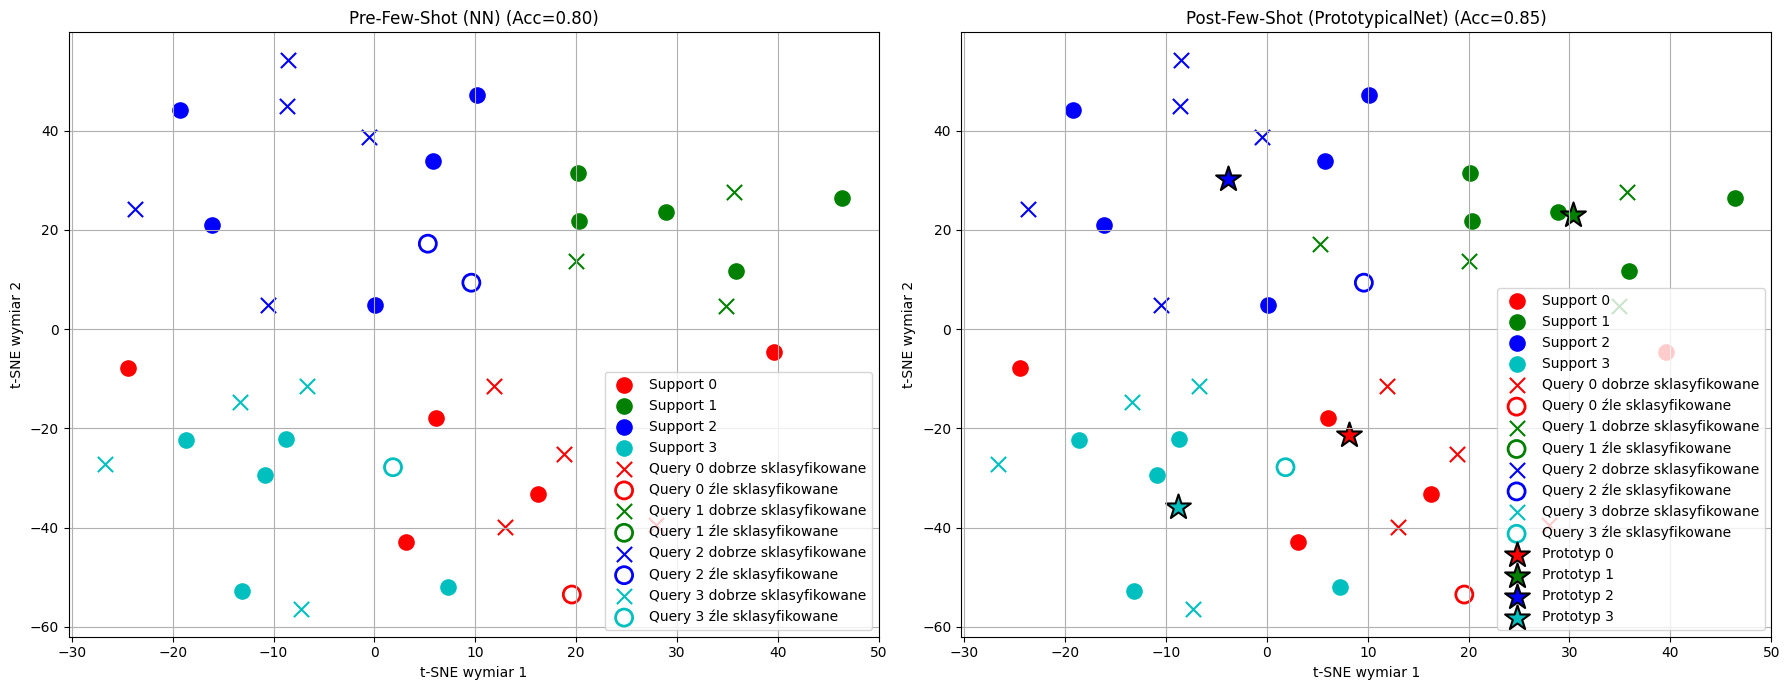

In [9]:
all_embeds = torch.cat([support_embeds, query_embeds], dim=0).cpu().numpy()

tsne = TSNE(n_components=2, random_state=42, perplexity=10)
tsne_embeddings_2d = tsne.fit_transform(all_embeds)

num_support = support_embeds.shape[0]
support_2d = tsne_embeddings_2d[:num_support]
query_2d   = tsne_embeddings_2d[num_support:]

# Obliczamy prototypy w 2D dla t-SNE 
support_y_np = support_y.cpu().numpy()

prototypes_2d = np.stack([
    support_2d[support_y_np == class_label].mean(axis=0)
    for class_label in range(n_way)
])


fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Nearest Neighbor 
plot_tsne(
    axes[0],
    pre_preds.cpu().numpy(),
    f"Pre-Few-Shot (NN) (Acc={pre_acc:.2f})",
    n_way,
    support_2d,
    query_2d,
    support_y_np,
    query_y
)

# Prototypical Network
plot_tsne(
    axes[1],
    post_preds.cpu().numpy(),
    f"Post-Few-Shot (PrototypicalNet) (Acc={post_acc:.2f})",
    n_way,
    support_2d,
    query_2d,
    support_y_np,
    query_y,
    show_prototypes=True,
    prototypes_2d=prototypes_2d
)

plt.tight_layout()
plt.show()

### Objaśnienie wykresów t-SNE

- **Gwiazdy (\*)** – prototypy klas (tylko w metodach, które je wyznaczają, np. Prototypical Network).  
- **Koła (●)** – przykłady ze zbioru wsparcia (support set).  
- **Pierścienie (○)** – źle sklasyfikowane punkty zapytania (query points).  
- **Krzyżyki (x)** – poprawnie sklasyfikowane punkty zapytania.  

**Wymiary t-SNE** to reprezentacja 2D wysokowymiarowych embeddingów. Algorytm t-SNE stara się odwzorować podobieństwa między punktami: punkty, które były blisko siebie w oryginalnej przestrzeni cech, pozostają blisko w płaszczyźnie 2D.

**Na co warto zwrócić uwagę:**  
- Czy punkty zapytania (x i ○) znajdują się w pobliżu swoich prototypów lub klastrów punktów wsparcia – to sprawdzenie, czy model prawidłowo grupuje podobne przykłady.  
- Klastry, w których występują źle sklasyfikowane punkty (○), mogą wskazywać obszary, gdzie model ma trudności z rozróżnieniem klas.  
- Im bliżej punkty pomocnicze znajdują się prototypu (tzn. tworzą spójny klaster), tym lepiej prezentuje on klasę.
- Porównanie dwóch wykresów przed i po few-shot learning)pozwala zobaczyć, jak zastosowanie bardziej zaawansowanej metody poprawia klasyfikację na podstawie stworzonych embeddingów.

Podobne wykresy zawarte są w dalszej części notebooka, nie zawierają jednak prototypów, które są wyjątkowe dla tej metody.


## Matching Networks - wykorzystanie mechanizmu atencji

Matching Networks to podejście w few-shot learning, które rozszerza ideę Prototypical Networks, porównując każdy przykład zapytania (*query*) ze **wszystkimi** przykładami pomocnyczymi, zamiast obliczać pojedynczy prototyp dla klasy. Pozwala to modelowi uchwycić bardziej szczegółowe relacje w zbiorze pomocniczym, co jest szczególnie przydatne, gdy zbiór danych jest "trudniejszy".

[Źródło: Vinyals et al., 2016](https://arxiv.org/abs/1606.04080)

---

### Główne mechanizmy

- **Porównanie ze zbiorem pomocniczym:**  
  Każdy embedding zapytania porównywany jest z **każdym** embeddingiem wsparcia za pomocą funkcji podobieństwa (np. podobieństwo cosinusowe lub iloczyn skalarny).

- **Predykcja z wagami atencji:**  
  W Matching Networks predykcja zapytania to **ważona suma etykiet przykładów pomocniczych**, gdzie wagi są wyznaczane na podstawie podobieństwa do zapytania.

  Niech $q$ będzie przykładem zapytania, a $S = \{(x_i, y_i)\}$ zbiorem pomocniczym. Wówczas przewidywana etykieta to:

  $$
  \hat{y}_q = \sum_{i \in S} a(q, x_i) \, y_i
  $$

  Wagi atencji $a(q, x_i)$ oblicza się jako softmax z podobieństw:

  $$
  a(q, x_i) = \frac{\exp(\text{sim}(f(q), f(x_i)))}{\sum_{j \in S} \exp(\text{sim}(f(q), f(x_j)))} \,,
  $$

  gdzie:  
  - $f(\cdot)$ to funkcja tworząca embedding,  
  - $\text{sim}(\cdot, \cdot)$ to funkcja podobieństwa (cosine similarity, iloczyn skalarny),  
  - $y_i$ to klasa przykładu pomocniczego $x_i$ (zwykle zakodowana w postaci one-hot).  

  Dzięki temu zapytanie może "skupić uwagę" na najbardziej istotnych przykładach ze zbioru pomocniczego, ważąc ich wpływ na końcową predykcję.  
  Przewidywana klasa: $argmax(\hat{y}_q)$

- **Embeddingi kontekstowe (rozszerzenie podstawowej metody):**  
To zagadnienie jest przedstawione w dodatkowym zadaniu 2.

[Źródło: Vinyals et al., 2016](https://arxiv.org/abs/1606.04080).

---

### Matching Networks- cechy

| Cechy | Matching Network |
|-------|----------------|
| Reprezentacja klasy | Wszystkie punkty pomocnicze |
| Porównanie zapytania | Query ↔ Wszystkie embeddingi punktów pomocniczych + atencja |
| Elastyczność | Lepiej radzi sobie z "trudniejszymi" zbiorami danych niż poprzednia metoda |
| Złożoność | Wyższa niż w poprzedniej metodzie |


---

### Zalety Matching Networks

- Umożliwia dokładniejsze uchwycenie informacji ze zbioru pomocniczego  
- Lepiej adaptuje się do danych z bardziej złożonych rozkładów  
- Można wykorzystać wizualizowane wag atencji aby uzyskać wgląd w to, które przykłady pomocnicze wpływają na predykcję

[Źródło: Vinyals et al., 2016](https://arxiv.org/abs/1606.04080)

In [10]:
# Matching Network
query_norm = F.normalize(query_embeds, dim=1)
support_norm = F.normalize(support_embeds, dim=1)

sim_matrix = torch.matmul(query_norm, support_norm.T)

attention = torch.softmax(sim_matrix, dim=1)

support_onehot = torch.zeros(support_y.size(0), n_way).to(device)
support_onehot[torch.arange(support_y.size(0)), support_y] = 1

post_preds = attention.to(device) @ support_onehot.to(device)
post_preds = post_preds.argmax(dim=1)

post_acc = (post_preds == query_y).float().mean().item()

In [11]:
few_shot_comparison("Baseline - Nearest Neighbor", "Matching Network", pre_acc, post_acc, n_way, k_shot, n_query)

Porównanie skuteczności Few-Shot Learning
----------------------------------------
Liczba klas (n-way): 4, Liczba przykładów na klasę (k-shot): 5, Liczba zapytań na klasę: 5

Dokładność (accuracy) przed few-shot (Baseline - Nearest Neighbor): 0.80
Dokładność (accuracy) po few-shot (Matching Network):      0.90

Poprawa dzięki few-shot learning: +0.10


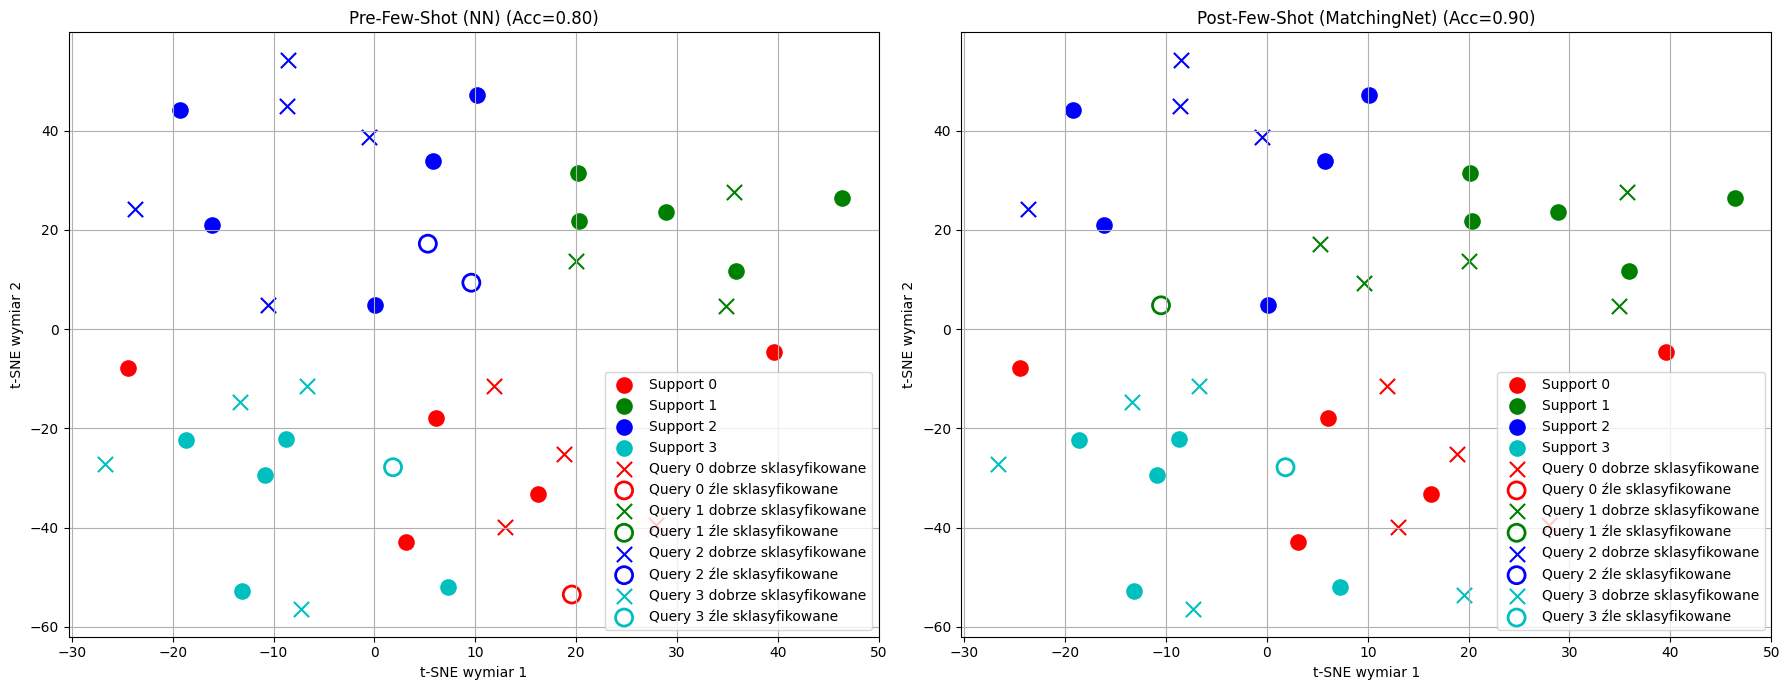

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

plot_tsne(
    axes[0],
    pre_preds.cpu().numpy(),
    f"Pre-Few-Shot (NN) (Acc={pre_acc:.2f})",
    n_way,
    support_2d,
    query_2d,
    support_y_np,
    query_y
)

plot_tsne(
    axes[1],
    post_preds.cpu().numpy(),
    f"Post-Few-Shot (MatchingNet) (Acc={post_acc:.2f})",
    n_way,
    support_2d,
    query_2d,
    support_y_np,
    query_y,
)

plt.tight_layout()
plt.show()

- **Koła (●)** – przykłady ze zbioru wsparcia (support set).  
- **Pierścienie (○)** – źle sklasyfikowane punkty zapytania (query points).  
- **Krzyżyki (x)** – poprawnie sklasyfikowane punkty zapytania. 

## Siamese Networks: uczenie poprzez podobieństwa par

Siamese Networks (sieci syjamskie) to architektura, która uczy jedną wspólną sieć neuronową oceniającą, czy dwa przykłady pochodzą z tej samej klasy — tzn. sieć uczy się funkcji podobieństwa, a nie bezpośrednio przewidywania etykiet. Nazwa "syjamska" wynika z tego, że podczas treningu sieć przyjmuje dwa wejścia, które przechodzą przez tę samą architekturę (tę samą sieć i te same wagi), tworząc embeddingi w tej samej przestrzeni cech.  

> W teorii można by użyć **dwóch fizycznie oddzielnych sieci** (sieci syjamskie) o identycznej architekturze do przetwarzania obu wejść, ale w praktyce stosuje się jedną sieć, aby zapewnić, że wagi i embeddingi są spójne dla obu przykładów.

To działanie przypomina mechanizm użyty w SimCLR, gdzie model także porównuje pary przykładów w celu nauki reprezentacji.


 
[Źródło: Koch et al., 2015](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf)

---

### Główne mechanizmy

- **Porównanie parami:** Sieć przyjmuje **dwa wejścia naraz** i zwraca wynik podobieństwa. Odpowiada na pytanie „czy te dwa przykłady pochodzą z tej samej klasy?”  

- **Wspólna sieć embeddingów:** Oba wejścia przechodzą przez tę samą sieć neuronową $f_\theta(\cdot)$ (tę samą architekturę i wagi), aby ich reprezentacje znajdowały się w tej samej przestrzeni cech. Niech $x_1, x_2$ będą dwoma przykładami, wówczas:  
$$
h_1 = f_\theta(x_1), \quad h_2 = f_\theta(x_2)
$$

- **Funkcja podobieństwa:** Na embeddingach stosuje się metrykę odległości lub podobieństwa (np. L1, L2, cosinus):  
$$
d(x_1, x_2) = \| h_1 - h_2 \|_1 \quad \text{lub} \quad d(x_1, x_2) = \text{cosine}(h_1, h_2)
$$

- **Trening z kontrastową stratą:** Pary przykładów są oznakowane jako **podobne (ta sama klasa)** lub **niepodobne (różne klasy)**. Sieć uczy się minimalizować odległość dla podobnych par i maksymalizować odległość dla niepodobnych par Przykład kontrastowej straty (*contrastive loss*):  
$$
\mathcal{L} = y \cdot d(x_1, x_2)^2 + (1-y) \cdot \max(0, m - d(x_1, x_2))^2
$$
gdzie:  
- $y = 1$ jeśli ta sama klasa, w przeciwnym razie 0  
- $m$ = margines dla par niepodobnych  

- **Predykcja:** Podczas testu zapytanie porównywane jest z przykładami pomocniczymi. Klasa najbliższego przykładu ze zbioru pomocniczego (nearest neighbor) jest przypisywana zapytaniu.  

---

### Siamese Network - cechy

| Cechy | Siamese Network |
|-------|----------------|
| Reprezentacja klasy | Embeddingi parami |
| Porównanie zapytania | Query ↔ Pojedynczy przykład wsparcia |
| Elastyczność | Bardzo wysoka |
| Złożoność | Wysoka w porównaniu z poprzednimi metodami, wymaga rzeczywistego treningu modelu (lub ostatniej warstwy) |

---

### Zalety Siamese Networks

- Łatwo generalizuje do nieznanych klas  
- Uczy niezależnej od klasy funkcji podobieństwa  
- Wymaga tylko etykiet, par nie pełnej informacji o klasach (tzn. model musi wiedzieć tylko, czy 2 podane przykłady należa do tej samej klasy, czy nie) 
- Elastyczne: działa nawet przy jednym przykładzie na klasę  

[Źródło: Koch et al., 2015](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf)


In [13]:
margin = 1.0  # dla kontrastowej straty
learning_rate = 1e-3     
n_epochs = 100 

# Przygotowanie par do trenowania 
def create_pairs(embeddings, labels):
    pair_list = []
    pair_targets = []
    num_samples = len(labels)
    for idx_i in range(num_samples):
        for idx_j in range(idx_i + 1, num_samples):
            pair_list.append((embeddings[idx_i], embeddings[idx_j]))
            pair_targets.append(1 if labels[idx_i] == labels[idx_j] else 0)
    stacked_pairs = torch.stack([torch.stack([p[0], p[1]]) for p in pair_list])
    return stacked_pairs, torch.tensor(pair_targets, dtype=torch.float32)

backbone_model = model 

# Uczymy tylko dodatkową warstwę projekcyjną
embedding_dim = support_embeds.shape[1]
projection_layer = nn.Sequential(
    nn.Linear(embedding_dim, 256),
    nn.ReLU(),
    nn.Linear(256, 128)
).to(device)

optimizer = torch.optim.Adam(projection_layer.parameters(), lr=learning_rate)

# Trenowanie na zbiorze pomocniczym
support_embeddings_detached = support_embeds.detach()  # nie trenujemy backbone

pair_samples, pair_labels = create_pairs(support_embeddings_detached, support_y)
pair_samples, pair_labels = pair_samples.to(device), pair_labels.to(device)

for epoch in range(n_epochs):
    optimizer.zero_grad()
    
    # Embeddingi z warstwy projekcji
    projected_1 = projection_layer(pair_samples[:,0])
    projected_2 = projection_layer(pair_samples[:,1])
    
    # Kontrastowa strata
    distances = F.pairwise_distance(projected_1, projected_2)
    contrastive_loss = (pair_labels * distances.pow(2) + 
                        (1 - pair_labels) * F.relu(margin - distances).pow(2)).mean()
    
    contrastive_loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {contrastive_loss.item():.4f}")

# Predykcja dla zapytań 
with torch.no_grad():
    support_projected = projection_layer(support_embeds)
    query_projected   = projection_layer(query_embeds)
    
    # Macierz podobieństw (cosine similarity)
    support_normalized = F.normalize(support_projected, dim=1)
    query_normalized   = F.normalize(query_projected, dim=1)
    similarity_matrix = torch.matmul(query_normalized, support_normalized.T)
    
    # Nearest neighbor
    nearest_indices = similarity_matrix.argmax(dim=1)
    post_preds = support_y[nearest_indices]
    
    post_accuracy = (post_preds == query_y).float().mean().item()
    print(f"\nDokładność po trenowaniu Siamese Network: {post_accuracy:.4f}")


Epoch 10/100, Loss: 0.0422
Epoch 20/100, Loss: 0.0064
Epoch 30/100, Loss: 0.0023
Epoch 40/100, Loss: 0.0007
Epoch 50/100, Loss: 0.0003
Epoch 60/100, Loss: 0.0001
Epoch 70/100, Loss: 0.0000
Epoch 80/100, Loss: 0.0000
Epoch 90/100, Loss: 0.0000
Epoch 100/100, Loss: 0.0000

Dokładność po trenowaniu Siamese Network: 0.9000


In [14]:
few_shot_comparison("Baseline - Nearest Neighbor", "Siamese Network", pre_acc, post_acc, n_way, k_shot, n_query)

Porównanie skuteczności Few-Shot Learning
----------------------------------------
Liczba klas (n-way): 4, Liczba przykładów na klasę (k-shot): 5, Liczba zapytań na klasę: 5

Dokładność (accuracy) przed few-shot (Baseline - Nearest Neighbor): 0.80
Dokładność (accuracy) po few-shot (Siamese Network):      0.90

Poprawa dzięki few-shot learning: +0.10


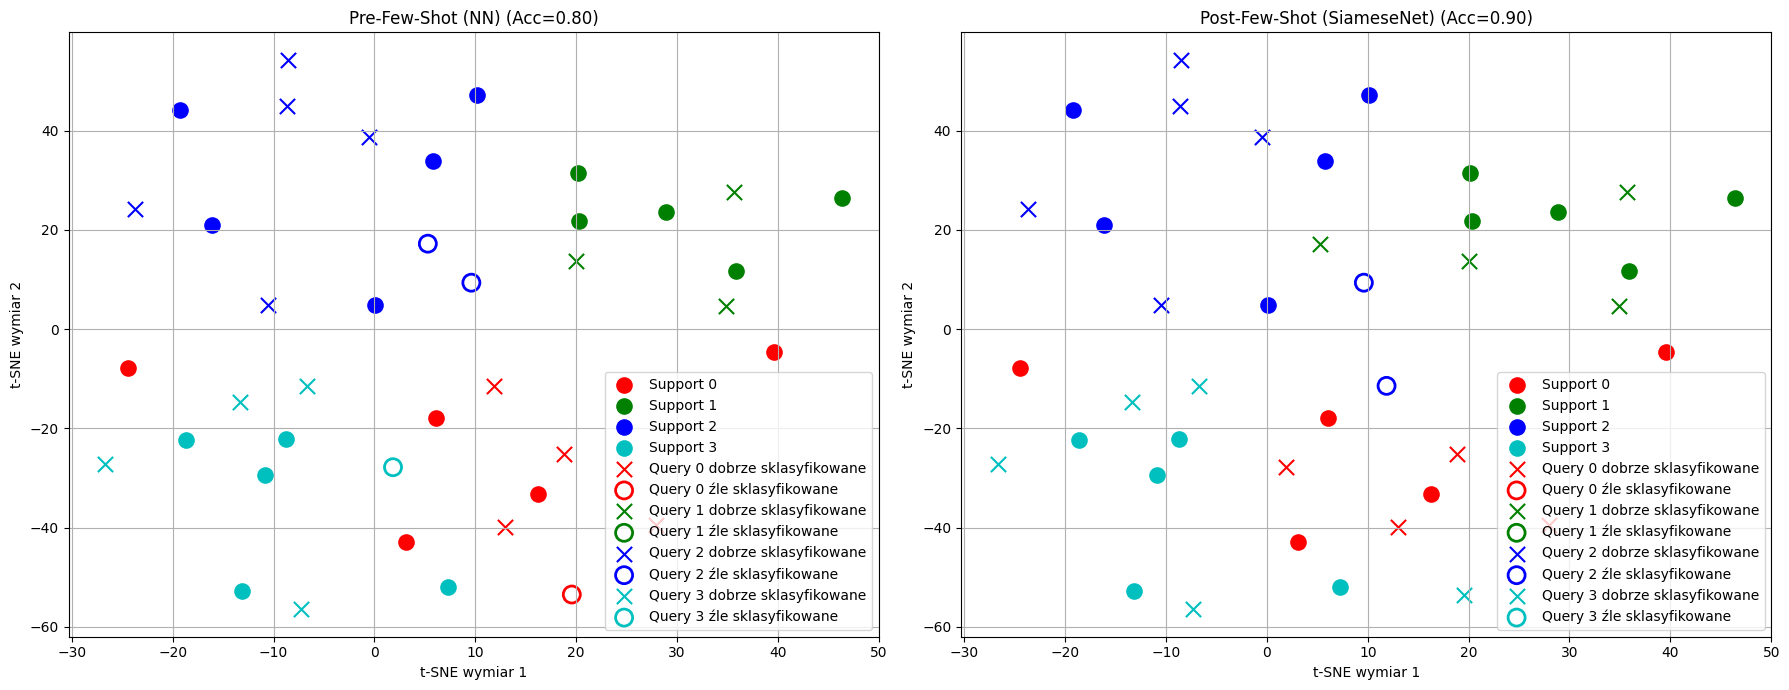

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

plot_tsne(
    axes[0],
    pre_preds.cpu().numpy(),
    f"Pre-Few-Shot (NN) (Acc={pre_acc:.2f})",
    n_way,
    support_2d,
    query_2d,
    support_y_np,
    query_y
)

plot_tsne(
    axes[1],
    post_preds.cpu().numpy(),
    f"Post-Few-Shot (SiameseNet) (Acc={post_acc:.2f})",
    n_way,
    support_2d,
    query_2d,
    support_y_np,
    query_y,
)

plt.tight_layout()
plt.show()

- **Koła (●)** – przykłady ze zbioru wsparcia (support set).  
- **Pierścienie (○)** – źle sklasyfikowane punkty zapytania (query points).  
- **Krzyżyki (x)** – poprawnie sklasyfikowane punkty zapytania. 

## Podsumowanie

### Dlaczego metody metryczne działają w Few-Shot Learning?

- **Nie trzeba trenować dużego klasyfikatora** – wystarczy porównywać odległości, ewentualnie dodać i dotrenować ostatnią wartstwę.  
- **Wykorzystują wcześniej wyuczone reprezentacje cech** – sieć embeddingów może być wstępnie wytrenowana na innych danych.  
- **Skalowalne do nowych klas** – dodanie nowej klasy jest proste, nie wymaga treningu całego modelu na nowo.  

**W skrócie:** Few-shot learning oparty na metrykach zakłąda klasyfikację na podstawie odległości między embeddingami stworzonymi przed wcześniej wytrenowany model.

### Porównanie przedstawionych metod metrycznych: 

| Cechy | Prototypical Network | Matching Network | Siamese Network |
|-------|--------------------|----------------|----------------|
| Reprezentacja klasy | Prototyp (średnia) | Wszystkie punkty pomocnicze | Embeddingi parami |
| Porównanie zapytania | Query ↔ Prototyp | Query ↔ Wszystkie embeddingi punktów pomocniczych + atencja | Query ↔ Pojedynczy przykład wsparcia |
| Elastyczność | Ograniczona do średniej klasy | Lepiej radzi sobie z "trudniejszymi" zbiorami danych niż poprzednia metoda | Bardzo wysoka |
| Złożoność | Niska | Wyższa niż w poprzedniej metodzie | Wysoka w porównaniu z poprzednimi dwoma metodami, wymaga rzeczywistego treningu modelu (lub ostatniej warstwy) |


### Ćwiczenie 1 (obowiązkowe): Odpowiedz na pytanie

**Pytanie:**  
Dlaczego niektóre punkty na wizualizacji t-SNE wydają się być otoczone punktami tej samej klasy, a mimo to są oznaczone jako błędnie sklasyfikowane? Innymi słowy, dlaczego punkty, które wizualnie wydają się „w odpowiednim klastrze”, mają niepoprawne przewidywane etykiety? (Wymień przynajmniej 2 powody).

Zwróć uwagę zarówno na metodę używaną do klasyfikacji, jak i na sposób, w jaki t-SNE generuje wizualizację.

### Ćwiczenie 2 (dodatkowe): Uzupełnij kod


**Embeddingi kontekstowe (rozszerzenie metody Matching Networks):**  

W oryginalnej pracy o Matching Networks autorzy kontekstualizują embeddingi przy użyciu BiLSTM w zbiorze pomocniczym. Oznacza to, że każdy przykład „widzi” pozostałe przykłady w zbiorze i może lepiej uwzględniać ich wzajemne relacje podczas klasyfikacji.
BiLSTM (Bidirectional LSTM) to rodzaj sieci rekurencyjnej, która analizuje sekwencje w obu kierunkach, pozwalając modelowi uwzględniać zarówno wcześniejsze, jak i późniejsze przykłady w sekwencji.

W odróżnieniu od podstawowej wersji, która traktuje każdy przykład ze zbioru pomocniczego niezależnie, kontekstualizacja pozwala modelowi korzystać z informacji o całym     zbiorze wsparcia wraz z uwzględnieniem relacji między punktami w zbiorze wsparcia, co może poprawić wyniki 

W tym ćwiczeniu należy zaimplementować przedstawioną metodę z BiLSTM, aby kontekstualizować embeddingi support set i query set. 

In [ ]:
# BiLSTM dla kontekstualizacji 
support_embeds_tensor = support_embeds.unsqueeze(1)  # [n_support, 1, 512]

bilstm = ____ #TODO wykorzystując nn.LSTM(() zdefiniuj sieć blistm; sprawdź, jak sieć działa dla różnych wartości hiperparametrów

with torch.no_grad():
    support_context_output, _ = bilstm(support_embeds_tensor)
    support_context = support_context_output.squeeze(1)  # [n_support, 256]

# BiLSTM dla query set 
query_embeds_tensor = query_embeds.unsqueeze(1)  # [n_query, 1, 512]
with torch.no_grad():
    query_context_output, _ = bilstm(query_embeds_tensor)
    query_context = query_context_output.squeeze(1)  # [n_query, 256]

# Normalizacja 
support_norm = ____ #TODO wykonaj normalizacje skontekstualizowanego zbioru pomocnieczego
query_norm   = ____ #TODO wykonaj normalizacje skontekstualizowanego zbioru zapytań

# Similarity + Nearest Neighbor
sim_matrix = ____ #TODO oblicz similarity matrix ze znormalizomanych zbiorów 
max_indices = sim_matrix.argmax(dim=1)
post_preds = support_y[max_indices]

post_acc = (post_preds == query_y).float().mean().item()

In [ ]:
few_shot_comparison("Baseline - Nearest Neighbor", "Contextual Matching Network", pre_acc, post_acc, n_way, k_shot, n_query)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Pre-Few-Shot (NN baseline)
plot_tsne(
    axes[0],
    pre_preds.cpu().numpy(),
    f"Pre-Few-Shot (NN) (Acc={pre_acc:.2f})",
    n_way,
    support_2d,
    query_2d,
    support_y_np,
    query_y
)

# Post-Few-Shot (MAtching Network kontekstualny)
plot_tsne(
    axes[1],
    post_preds.cpu().numpy(),
    f"Post-Few-Shot (Contextual Matching Network) (Acc={post_acc:.2f})",
    n_way,
    support_2d,
    query_2d,
    support_y_np,
    query_y,
)

plt.tight_layout()
plt.show()